## CNN from scratch improved

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import plot_confusion_matrix as pcm
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-06-04 23:07:25.028596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

2023-06-04 23:07:29.707849: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 23:07:29.709888: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-04 23:07:29.710463: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-04 23:07:29.721863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 23:07:29.722024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

Num GPUs Available:  1


2023-06-04 23:07:31.688609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-04 23:07:31.688639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2023-06-04 23:07:31.688647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2023-06-04 23:07:31.689750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 23:07:31.690128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 23:07:31.690408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-

In [ ]:
# # Organize data into train, valid, test dirs
# os.chdir('../data/dogs-vs-cats')
# if os.path.isdir('train/dog') is False:
#     os.makedirs('train/dog')
#     os.makedirs('train/cat')
#     os.makedirs('valid/dog')
#     os.makedirs('valid/cat')
#     os.makedirs('test/dog')
#     os.makedirs('test/cat')

# ## We are going to work with a subset

#     for i in random.sample(glob.glob('cat*'), 2500):
#         shutil.move(i, 'train/cat')      
#     for i in random.sample(glob.glob('dog*'), 2500):
#         shutil.move(i, 'train/dog')
#     for i in random.sample(glob.glob('cat*'), 500):
#         shutil.move(i, 'valid/cat')        
#     for i in random.sample(glob.glob('dog*'), 500):
#         shutil.move(i, 'valid/dog')
#     for i in random.sample(glob.glob('cat*'), 250):
#         shutil.move(i, 'test/cat')      
#     for i in random.sample(glob.glob('dog*'), 250):
#         shutil.move(i, 'test/dog')

# os.chdir('../../')

In [3]:
#We then create variables for which the the paths to the train, valid, and test data directories are assigned

train_path = '../data/dogs-vs-cats/train'
valid_path = '../data/dogs-vs-cats/valid'
test_path = '../data/dogs-vs-cats/test'

In [4]:
#We use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories
## ImageDataGenerator.flow_from_directory() creates a DirectoryIterator, which generates batches of normalized tensor image data from the respective data directories.
### To flow_from_directory(), we first specify the path for the data. We then specify the target_size of the images, which will resize all images to the specified size. The size we specify here is determined by the input size that the neural network expects.
#### The classes parameter expects a list that contains the underlying class names, and lastly, we specify the batch_size.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 15000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

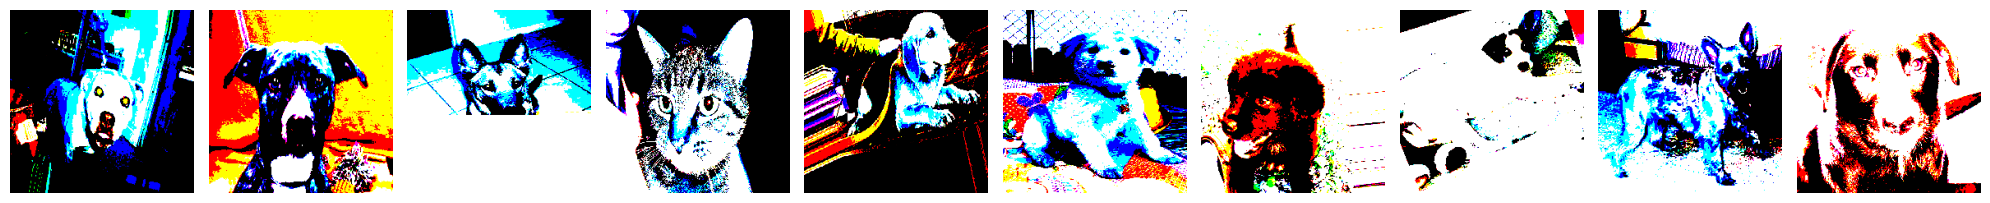

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [5]:
# Visualize data
import plotImages as pltI

imgs, labels = next(train_batches) # to generate a batch of images and labels from the training set, note that the size of this batch is determined by the batch_size we set when we created train_batches
#in this case it just create a batch of 10 random pics and labeled them. In a training this function will be in a for and, it will prepare input data for the CNN until it uses all of the images available

pltI.plotImages(imgs)
print(labels)

## The images colors appears to be distorted. This has to do with the VGG16 processing we applied to the data sets
### The RGB pixel data has been processed in such a way that the image data now looks like this before being passed to the network.

#Note that dogs are represented with the one-hot encoding of [0,1], and cats are represented by [1,0].

In [6]:
###################################################
## We will use a Keras sequential model for the CNN

model = Sequential([
    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224, 224,3)), ## The first layer in the model is a 2-dimensional convolutional layer. This layer will have 32 output filters each with a kernel size of 3x3, and we'll use the relu activation function. We enable zero-padding by specifying padding = 'same'.
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2), ## The max pooling layer is to pool and reduce the dimensionality of the data
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2), 
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'), 
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'), 
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'), 
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    #Flatten(), #We then Flatten the output from the convolutional layer and pass it to a Dense layer. 
    GlobalAveragePooling2D(),
    Dense(units=2, activation='softmax') # This Dense layer is the output layer of the network, and so it has 2 nodes, one for cat and one for dog. We'll use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

2023-06-04 23:08:25.023330: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-04 23:08:25.023522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 23:08:25.023642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-06-04 23:08:25.023676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-04 23:08:25.023708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-04 23:08:25.023718: I tensorflow/stream_executor/platform

In [9]:
#We compile the CNN the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#We will now train our CNN

model.fit(  x=train_batches,
            steps_per_epoch=len(train_batches), #len(train_batches)=1000 samples/batch_size=100
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10
1500/1500 - 58s - loss: 0.6593 - accuracy: 0.6249 - val_loss: 0.6444 - val_accuracy: 0.6620
Epoch 2/10
1500/1500 - 58s - loss: 0.6012 - accuracy: 0.6794 - val_loss: 0.5222 - val_accuracy: 0.7420
Epoch 3/10
1500/1500 - 58s - loss: 0.5309 - accuracy: 0.7427 - val_loss: 0.4720 - val_accuracy: 0.7810
Epoch 4/10
1500/1500 - 58s - loss: 0.4348 - accuracy: 0.8002 - val_loss: 0.3605 - val_accuracy: 0.8420
Epoch 5/10
1500/1500 - 58s - loss: 0.3609 - accuracy: 0.8403 - val_loss: 0.4786 - val_accuracy: 0.7980
Epoch 6/10
1500/1500 - 58s - loss: 0.3001 - accuracy: 0.8725 - val_loss: 0.2807 - val_accuracy: 0.8730
Epoch 7/10
1500/1500 - 58s - loss: 0.2485 - accuracy: 0.8943 - val_loss: 0.3183 - val_accuracy: 0.8670
Epoch 8/10
1500/1500 - 58s - loss: 0.2143 - accuracy: 0.9103 - val_loss: 0.2869 - val_accuracy: 0.8870
Epoch 9/10
1500/1500 - 58s - loss: 0.1777 - accuracy: 0.9277 - val_loss: 0.3221 - val_accuracy: 0.8860
Epoch 10/10
1500/1500 - 58s - loss: 0.1488 - accuracy: 0.9394 - val_loss:

#### In the above case we can see that our model is vastly overfitting to the training data, because the validation metrics are considerably worse than the training metrics.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

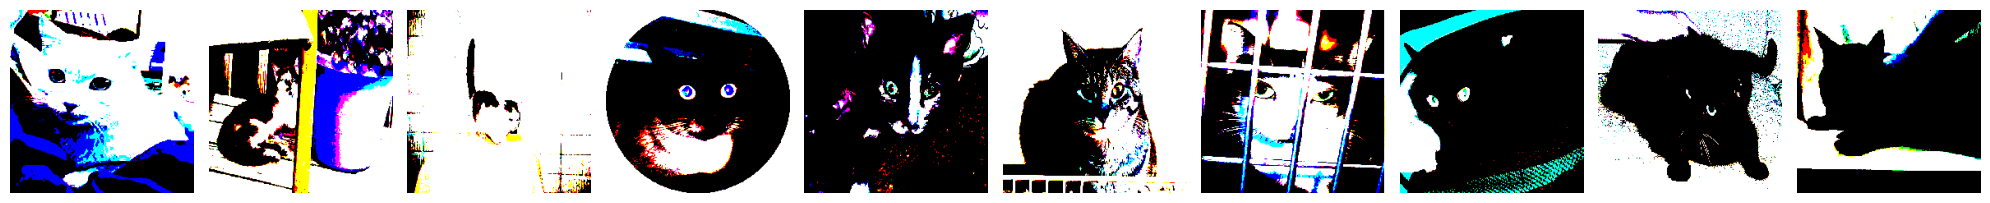

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [11]:
## Preparing Test Data

test_imgs, test_labels = next(test_batches)

pltI.plotImages(test_imgs)
print(test_labels)

In [12]:
## Predicting on the test data

predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

Confusion matrix, without normalization
[[229  21]
 [ 32 218]]


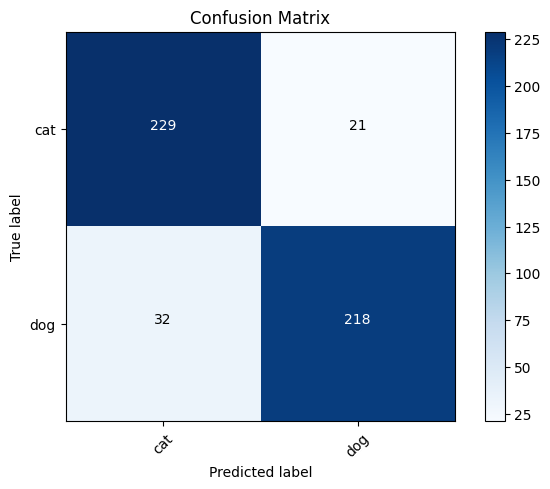

In [13]:
# Confusion matrix

cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)) ##Note, we can access the unshuffled true labels for the test set by calling test_batches.classes.
## We transform the one-hot encoded predicted labels to be in the same format as the true labels by only selecting the element with the highest value for each prediction using np.argmax(predictions, axis=-1)
cm_plot_labels = ['cat', 'dog']
pcm.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [14]:
# Guardo el modelo
model.save('models/CNNv2_2.h5')
